In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from Regressor import RegressorWrapper
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import logging
import re
import sqlite3
#Définition de constantes
AXE_COLONNES = 1

## Sources

| Sources_données_originales | Date_de_mise_à_jour |
| ---------------------------|---------------------|
| https://www.insee.fr/fr/statistiques/serie/010760415#Telechargement | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010760376#Telechargement | 26/01/23 |
| https://www.insee.fr/fr/statistiques/7076724#onglet-1 | 11/04/23 |
| https://www.insee.fr/fr/statistiques/7076722 | 07/04/23 |
| https://www.insee.fr/fr/statistiques/serie/010760261#Telechargement | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010760364#Telechargement | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010759840#Telechargement | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010759801#Telechargement | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010760261 | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010759955 | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010760300 | 26/01/23 |
| https://www.insee.fr/fr/statistiques/serie/010759801 | 26/01/23 |
| https://www.data.gouv.fr/fr/datasets/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-1er-tour/ | 14/04/2023 |
| https://www.data.gouv.fr/fr/datasets/election-presidentielle-des-23-avril-et-7-mai-2017-resultats-du-1er-tour/ | 24/04/2017 |
| https://www.data.gouv.fr/fr/datasets/election-presidentielle-2012-resultats-572124/ | 06/01/2014 |
| https://www.data.gouv.fr/fr/datasets/election-presidentielle-2007-resultats-572120/ | 06/01/2014 |
| https://www.data.gouv.fr/fr/datasets/bases-statistiques-communale-et-departementale-de-la-delinquance-enregistree-par-la-police-et-la-gendarmerie-nationales/ | 09/03/2023 |

# Traitement des données sur l'emploi
## Obtention des données

In [3]:
sns.set(rc={'figure.figsize':(20,8.27)})

In [4]:
def separer_numero_departement(valeur):
    valeur_a_comparer = valeur.strip().lower()
    if valeur_a_comparer == "loire atlantique":
       return 44
    elif valeur_a_comparer == "alpes-maritimes":
       return 6

In [5]:
def afficher_noms_colonnes_avec_valeurs_manquantes(dataframe):
  column_labels = list(dataframe.columns)
  for column_label in column_labels:
    if dataframe[column_label].hasnans:
      print(column_label)

In [6]:
sheet_names = ['Emploi LA', 'Emploi Indus LA', 'Tertiaire marchand LA', 'Tertiaire non march LA', 'Chom LA', 'Emploi AM', 'Emploi Indus AM', 'Tertiaire march AM', 'Tertiaire non march AM OK', 'Chom AM']
dict_donnees_insee = pd.read_excel("./data/donnees_insee.xlsx", sheet_name=sheet_names, skiprows=6)
dict_donnees_insee['Tertiaire non march AM OK'] = dict_donnees_insee['Tertiaire non march AM OK'].drop(33, axis=0)

for item in dict_donnees_insee.items():
   dataframe = dict_donnees_insee[item[0]]
   dataframe = dataframe.dropna(axis=0, how="all")
   dict_donnees_insee[item[0]] = dataframe
   #print(item[0], str(dict_donnees_insee[item[0]].shape))
dataframes = dict_donnees_insee.values()
dataset_insee = pd.concat(dataframes, axis=0,keys=sheet_names).reset_index(level=1,drop=True)
dataset_insee.insert(0,"N°_Departement",dataset_insee["Zone_geographique"].apply(separer_numero_departement))
dataset_insee = dataset_insee.drop("Zone_geographique", axis=AXE_COLONNES)
display(dataset_insee)

,N°_Departement,2001T4,2002T1,2002T2,2002T3,2002T4,2003T1,2003T2,2003T3,2003T4,...,2020T3,2020T4,2021T1,2021T2,2021T3,2021T4,2022T1,2022T2,2022T3,2022T4
Emploi LA,44,513549.0,519946.50,521034.5,522314.00,518667,519755.0,521034.5,522122.5,523019.0,...,608047.000000,608497.0,614328.000000,621391.000000,626772.000000,633914.0,637679.000000,640581.000000,643603.000000,645104.0
Emploi Indus LA,44,87440.0,87769.75,88099.5,88429.25,86121,86567.0,87013.0,87459.0,84337.0,...,85414.000000,85526.0,84912.500000,84299.000000,83685.500000,87980.0,87980.000000,87980.000000,87980.000000,NaN
Tertiaire marchand LA,44,290834.0,288973.00,288577.0,288965.00,287697,285539.0,286943.0,284718.0,283144.0,...,257727.000000,257244.0,257796.000000,258723.000000,259970.000000,261487.0,262210.000000,263290.000000,265222.000000,266202.0
Tertiaire non march LA,44,145778.0,146213.50,146649.0,147084.50,147520,148151.5,148783.0,149414.5,150046.0,...,185481.500000,185826.0,186265.500000,186705.000000,187144.500000,187584.0,187742.213883,187742.213883,187742.213883,188216.0
Chom LA,44,6.5,6.40,6.4,6.40,6.5,6.8,6.9,6.8,7.1,...,7.800000,6.9,6.900000,6.600000,6.600000,6.1,5.900000,6.000000,6.000000,5.8
Emploi AM,6,419917.0,421377.75,422838.5,424299.25,425760,427475.5,429191.0,430906.5,432622.0,...,407882.000000,408611.0,409196.000000,415839.000000,420726.000000,426287.0,429011.000000,433844.000000,432781.000000,434185.0
Emploi Indus AM,6,35203.8,35217.40,35246.8,35118.80,34933,34890.2,34942.4,34732.0,34553.2,...,31817.800000,31909.4,32180.000000,32351.400000,32612.600000,32824.2,32973.200000,33107.400000,33271.200000,33505.0
Tertiaire march AM,6,151712.4,153507.00,153934.4,154494.00,154861.4,155220.0,156114.0,156405.2,156726.6,...,179816.000000,178286.8,179505.400000,184554.600000,187511.400000,190263.2,191832.800000,193891.600000,194276.000000,194307.0
Tertiaire non march AM OK,6,121852.0,122561.75,123271.5,123981.25,124691,125509.5,126328.0,127146.5,127965.0,...,147455.535163,148145.0,158616.043261,159007.172189,159362.130132,159910.0,NaN,NaN,NaN,NaN
Chom AM,6,10.2,10.00,9.8,9.60,9.6,9.9,10.0,9.8,10.0,...,10.100000,9.1,9.300000,9.000000,8.900000,8.4,8.300000,8.200000,8.200000,8.0


## Traîtement des données manquantes sur l'emploi

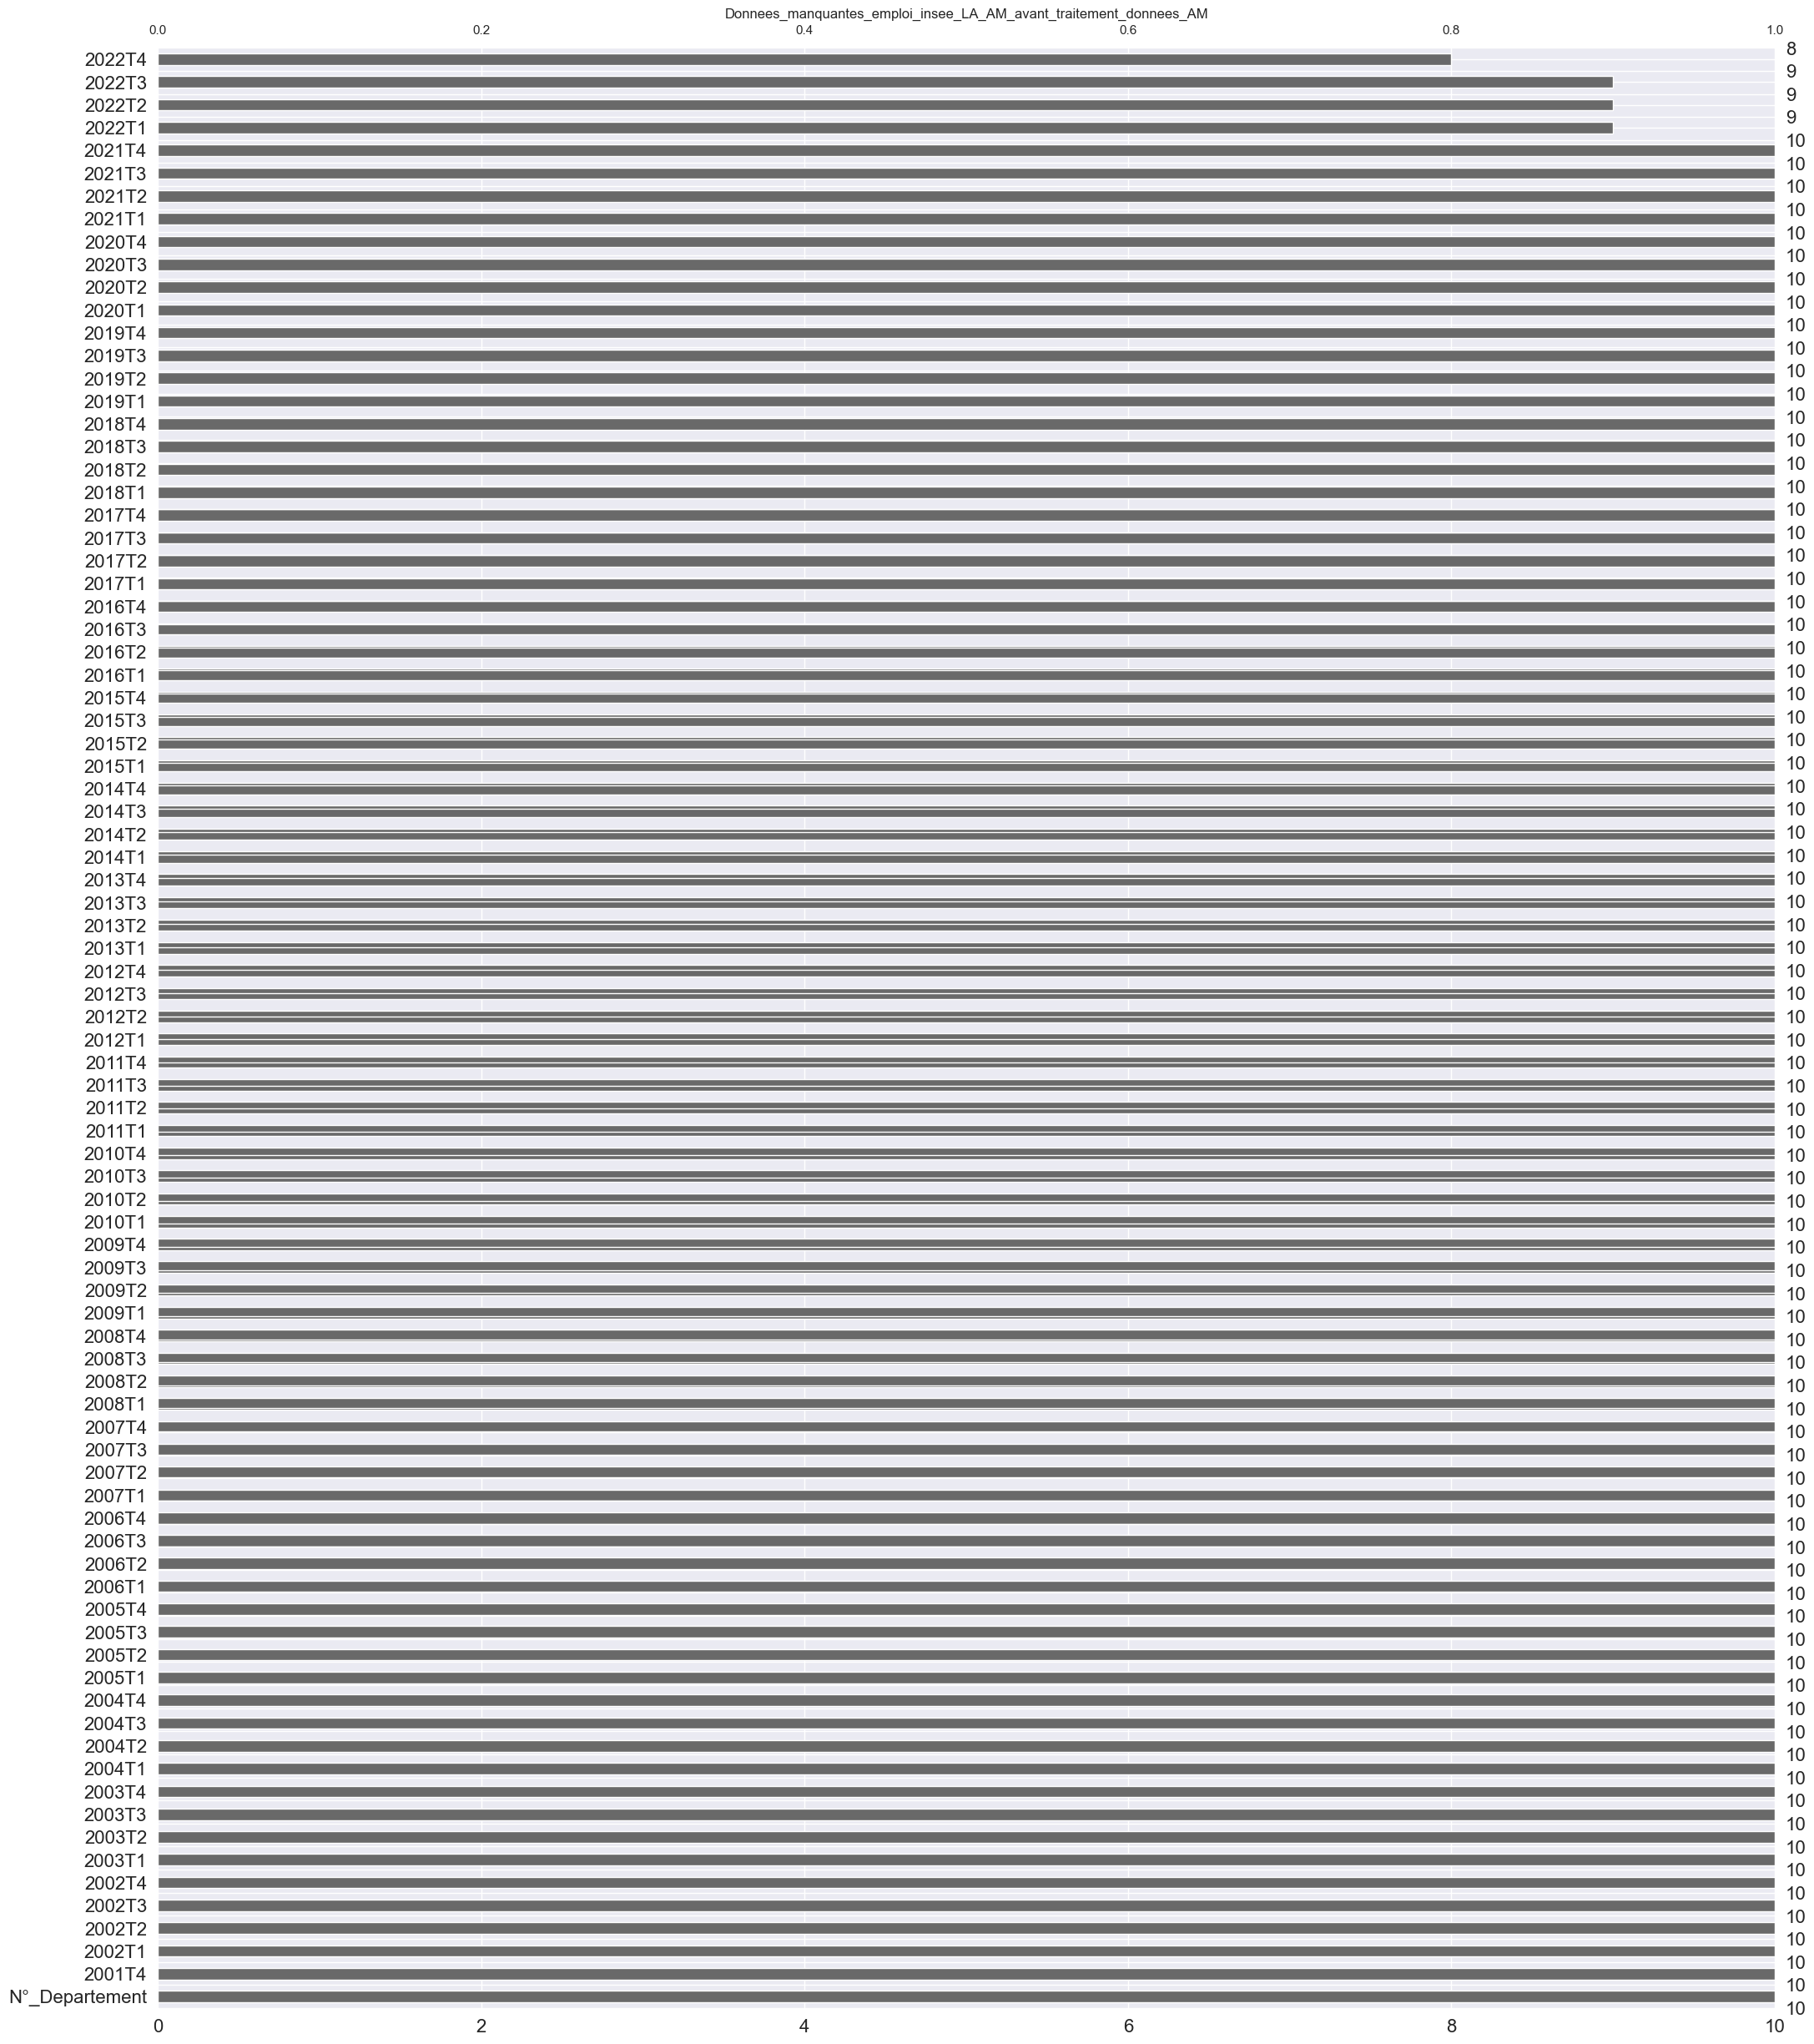

In [7]:
msno.bar(dataset_insee)
title = "Donnees_manquantes_emploi_insee_LA_AM_avant_traitement_donnees_AM"
plt.title(title)
plt.savefig(title + ".png")
plt.show()

In [8]:
nan_values_dataframe = dataset_insee.isna()
missing_values_row_indexes = nan_values_dataframe[(nan_values_dataframe["2022T1"] == True)|(nan_values_dataframe["2022T2"] == True)|(nan_values_dataframe["2022T3"].isnull().any() == True)|(nan_values_dataframe["2022T4"] == True)].index
missing_values_row_indexes
rows_w_missing_values = dataset_insee.loc[missing_values_row_indexes]
interesting_columns = [column for column in rows_w_missing_values if "2022" in column]
for column in interesting_columns :
    print("\n"+ column)
    print(rows_w_missing_values[column].isna())


2022T1
Emploi Indus LA              False
Tertiaire non march AM OK     True
Name: 2022T1, dtype: bool

2022T2
Emploi Indus LA              False
Tertiaire non march AM OK     True
Name: 2022T2, dtype: bool

2022T3
Emploi Indus LA              False
Tertiaire non march AM OK     True
Name: 2022T3, dtype: bool

2022T4
Emploi Indus LA              True
Tertiaire non march AM OK    True
Name: 2022T4, dtype: bool


## Régression linéaire sur la série Tertiaire non marchand AM présentant des données manquantes
### Détermination de la droite de régression linéaire (d'ajustement)

In [9]:
rows_w_missing_values.columns = range(rows_w_missing_values.columns.size)
regressor_wrappers_dict = {}
# Régression linéaire sur les données manquantes
previous_data_slice = slice(1,82)
target_slice = slice(82, None)
#Plaçage des features et des labels dans des tableaux à une dimension, Travail avec les données emploi Indus LA
x = rows_w_missing_values.columns[previous_data_slice].to_numpy().reshape(-1,1)
for i in range(len(rows_w_missing_values)):
    current_series_name = rows_w_missing_values.index[i]
    y = rows_w_missing_values.iloc[i,previous_data_slice].to_numpy().reshape(-1,1)
    #Découpage des données en jeux d'entraînement et de test
    #splitted_datasets_tuple = train_test_split(x, y, test_size=0.2, train_size=0.8)
    #Préparation des données à la régression linéaire
    #X_train, X_test, y_train, y_test = map(lambda dataset : dataset.reshape(1,dataset.shape[0]), splitted_datasets_tuple)
    
    regression_model = LinearRegression()
    # Adapter les données (entraînement du modèle)
    regression_model.fit(x,y)
    # Prédiction
    y_predicted = regression_model.predict(x)
    
    regressor_wrappers_dict[current_series_name] = RegressorWrapper(regression_model, x, y, y_predicted)
    r2 = r2_score(y, y_predicted)
    corr_coef = math.sqrt(r2)
    print(corr_coef)
    print(regression_model.intercept_)

0.3012612648782639
[83255.62808642]
0.94462803098395
[126506.09854048]


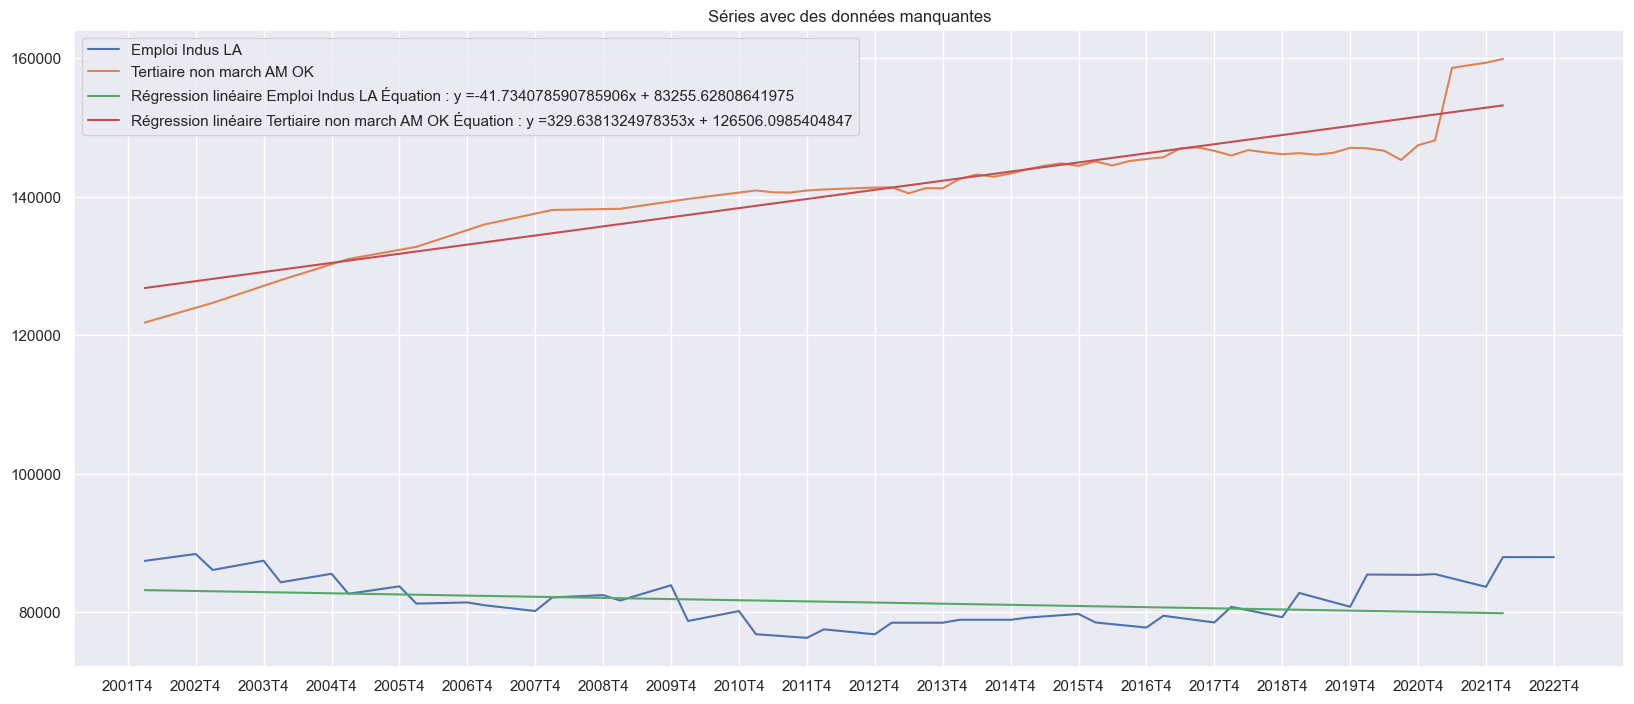

In [10]:
ticks_labels = list(dataset_insee.filter(axis=AXE_COLONNES, regex="\d{4}T4").columns)
x_y_axis_dataframe_slicing = slice(1,None)
title = "Séries avec des données manquantes"
for row_label in rows_w_missing_values.index:
    x = list(rows_w_missing_values.columns)[x_y_axis_dataframe_slicing]
    y = rows_w_missing_values.loc[row_label].iloc[x_y_axis_dataframe_slicing]
    plt.xticks(range(0,85,4),labels=ticks_labels)
    plt.plot(x,y,label=row_label)
for name,value in regressor_wrappers_dict.items():
    plt.plot(x[0:81], value.y_predicted, label="Régression linéaire " + name + " Équation : " + value.get_linear_equation())
plt.title(title)
plt.legend()
plt.savefig(title + ".png")
plt.show()

### Analyse des résidus pour l'emploi dans le secteur tertiaire en Alpes Maritimes

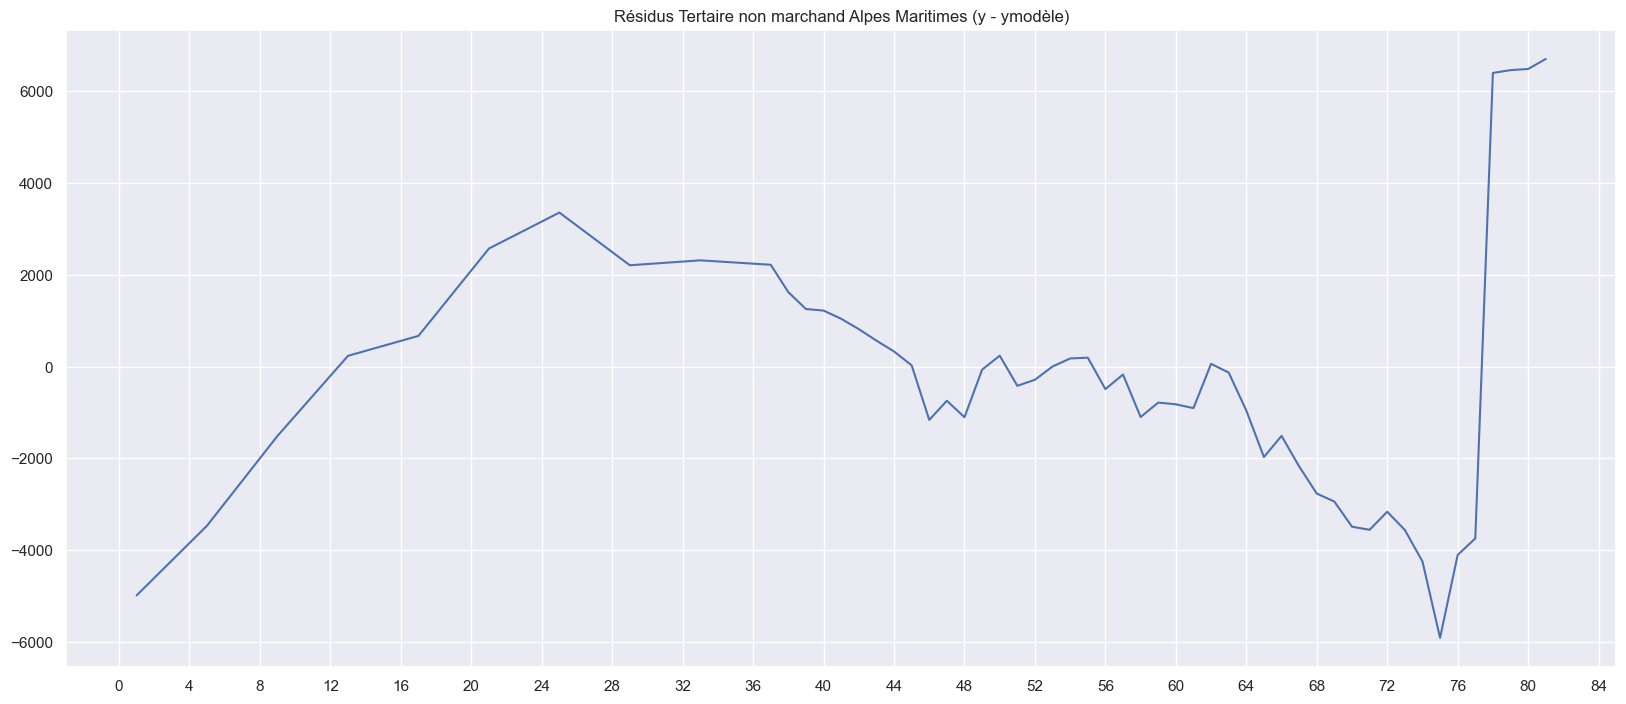

In [11]:
tnm_reg_wrapper = regressor_wrappers_dict[rows_w_missing_values.index[1]]
residuals = tnm_reg_wrapper.get_residuals()
title = "Résidus Tertaire non marchand Alpes Maritimes (y - ymodèle)"
plt.xticks(range(0,85,4))
plt.title(title)
plt.plot(tnm_reg_wrapper.x.tolist(),residuals)
plt.savefig(title + ".png")

### Remplissage des valeurs manquantes avec les prédictions du modèle de Régression linéaire sur les données de l'emploi dans le secteur marchand en Alpes-Maritimes

In [12]:
nan_values = rows_w_missing_values[rows_w_missing_values.columns[rows_w_missing_values.isnull().any()]]
for x in nan_values :
    row_label, column_label = ('Tertiaire non march AM OK',dataset_insee.columns[x])
    cell = dataset_insee.at[row_label, column_label]
    if cell != np.nan:
        dataset_insee.at[row_label, column_label] = tnm_reg_wrapper.predict(np.array([[x]]))

### Affichage de graphiques montrant les valeurs manquantes après le traitement des données du secteur Tertiaire non marchand Alpes Maritimes

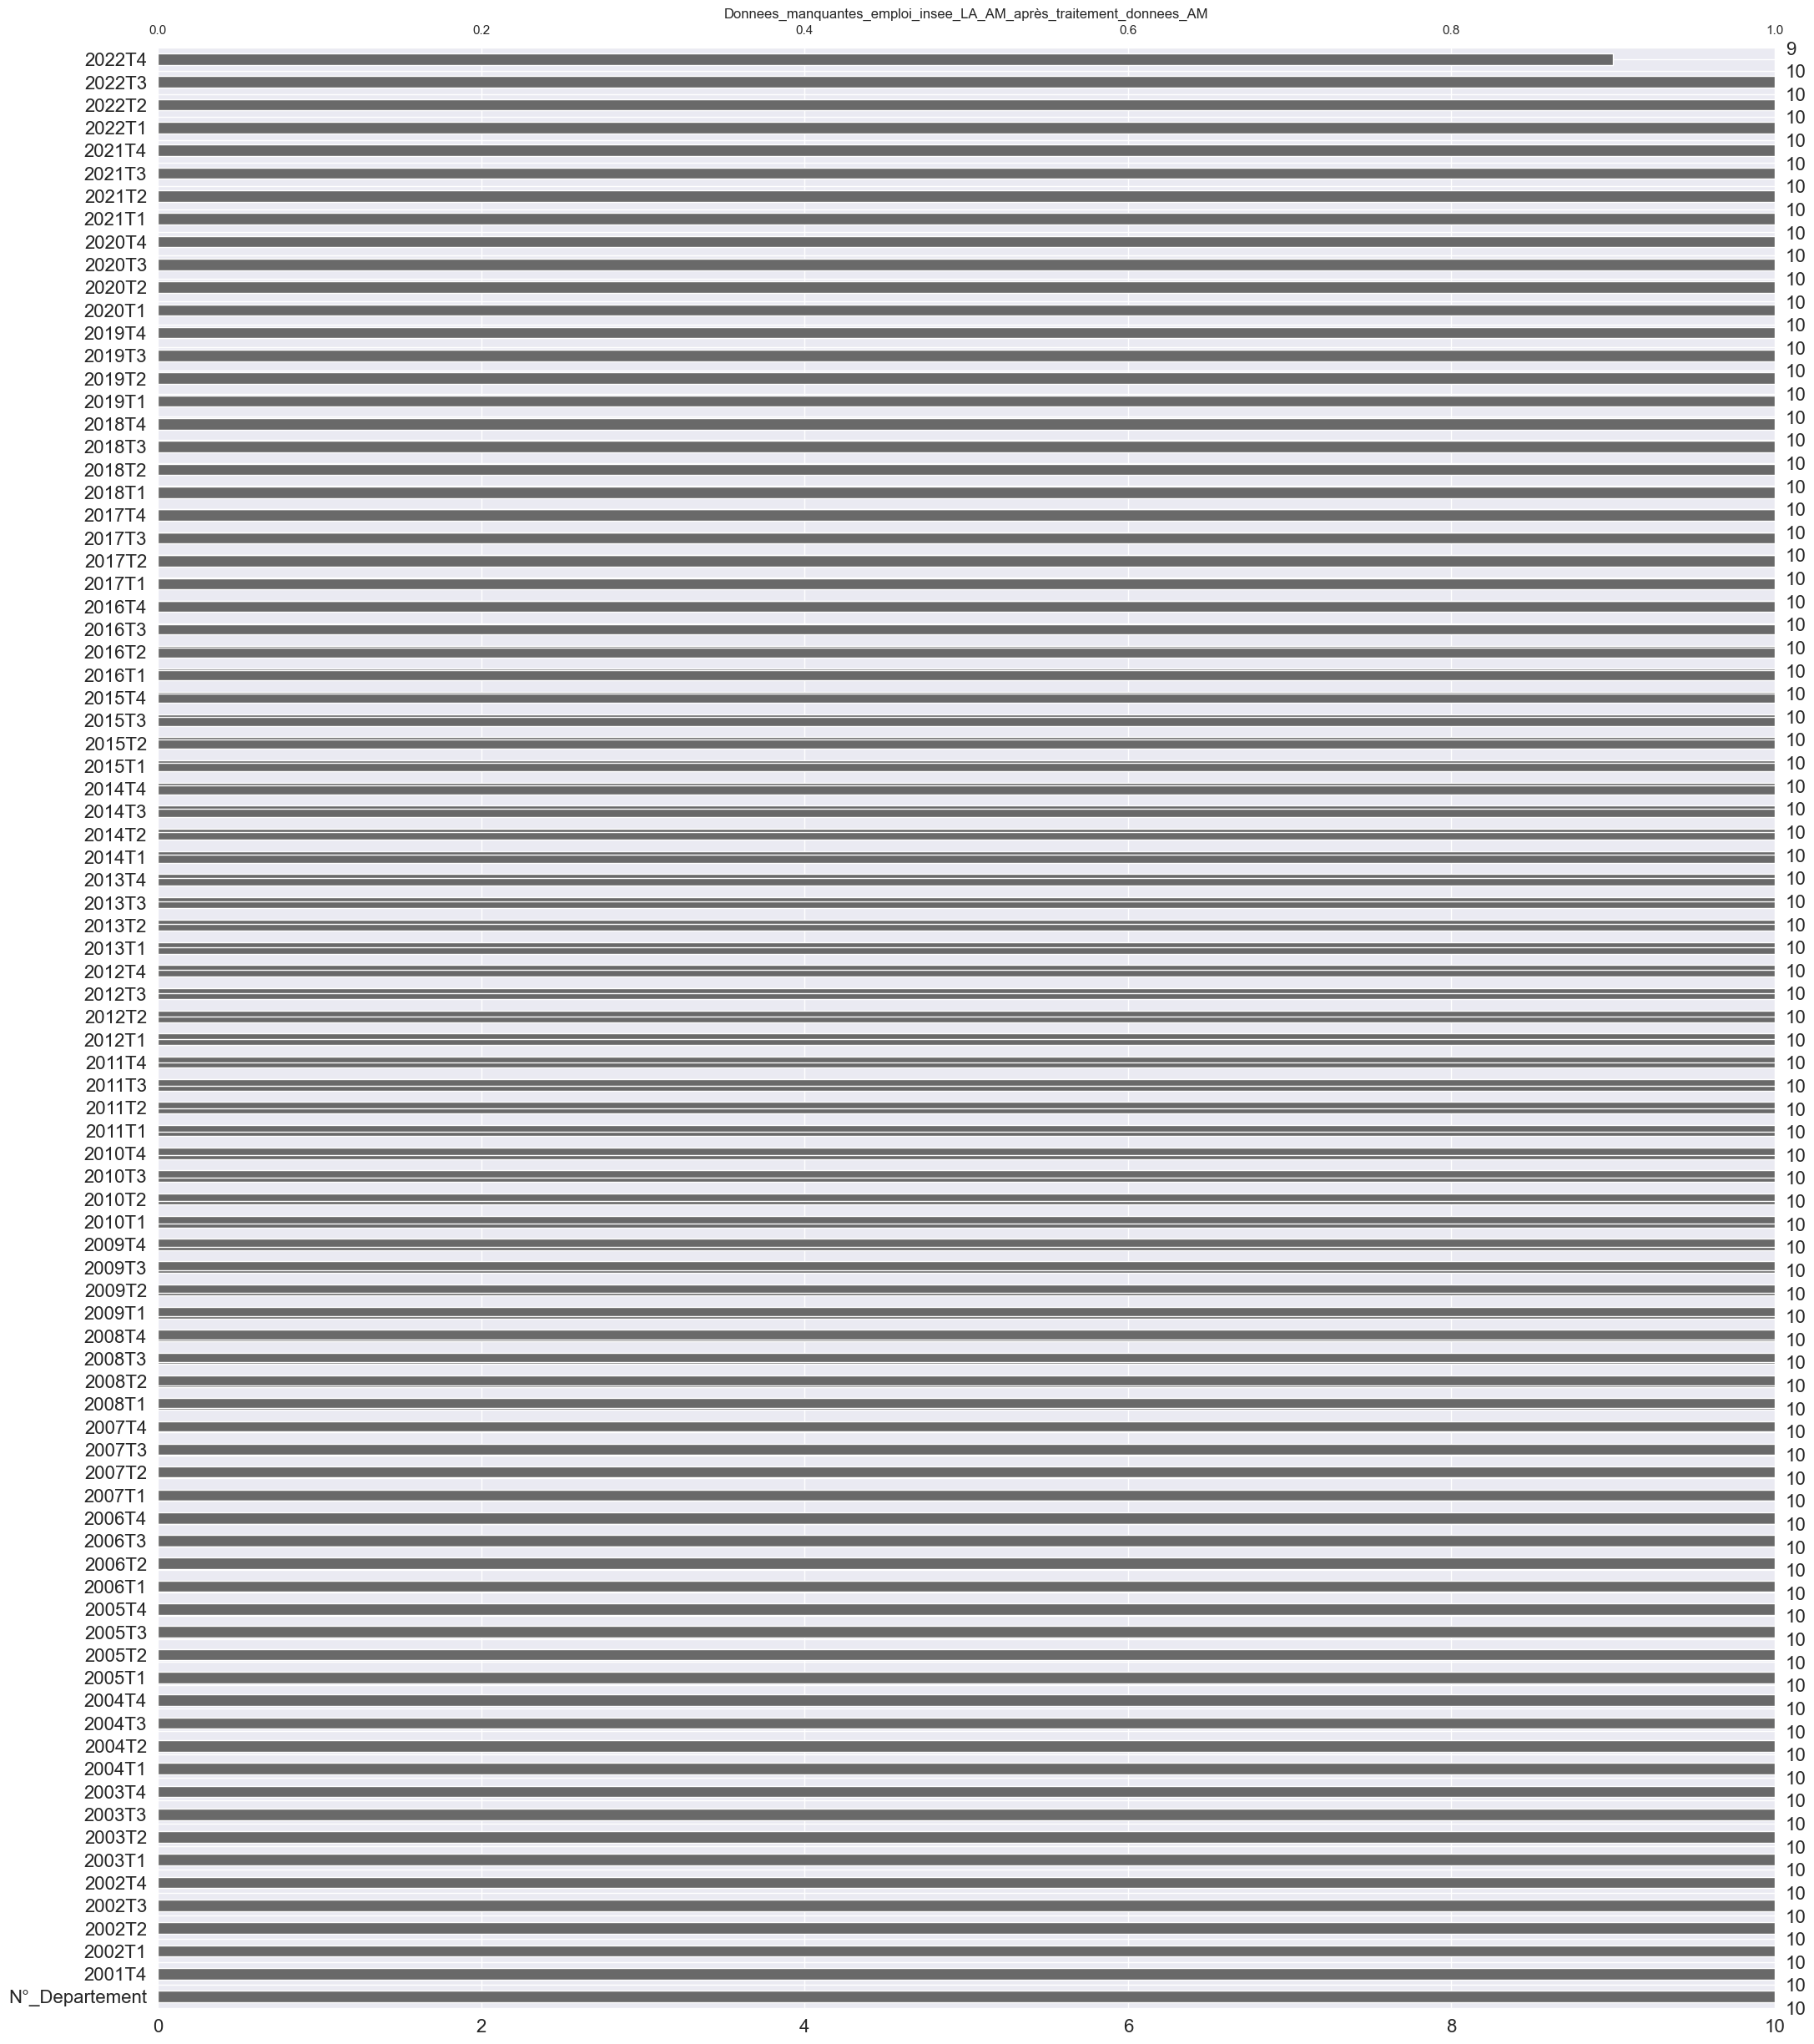

In [13]:
msno.bar(dataset_insee)
title = "Donnees_manquantes_emploi_insee_LA_AM_après_traitement_donnees_AM"
plt.title(title)
plt.savefig(title + ".png")
plt.show()

In [14]:
nan_values_dataframe = dataset_insee.isna()
missing_values_row_indexes = nan_values_dataframe[(nan_values_dataframe["2022T1"] == True)|(nan_values_dataframe["2022T2"] == True)|(nan_values_dataframe["2022T3"].isnull().any() == True)|(nan_values_dataframe["2022T4"] == True)].index
missing_values_row_indexes
rows_w_missing_values = dataset_insee.loc[missing_values_row_indexes]
rows_w_missing_values.isna().sum(axis=AXE_COLONNES)

Emploi Indus LA    1
dtype: int64

## Traitement des données manquantes sur la série Emploi Indus LA

### Essai de la méthode d'interpolation linéaire 

In [15]:
dataset_insee = dataset_insee.interpolate(method="linear")
dataset_insee["2022T2"]

Emploi LA                    640581.000000
Emploi Indus LA               87980.000000
Tertiaire marchand LA        263290.000000
Tertiaire non march LA       187742.213883
Chom LA                           6.000000
Emploi AM                    433844.000000
Emploi Indus AM               33107.400000
Tertiaire march AM           193891.600000
Tertiaire non march AM OK    153866.063538
Chom AM                           8.200000
Name: 2022T2, dtype: float64

### Affichage des données manquantes après la méthode d'interpolation linéaire

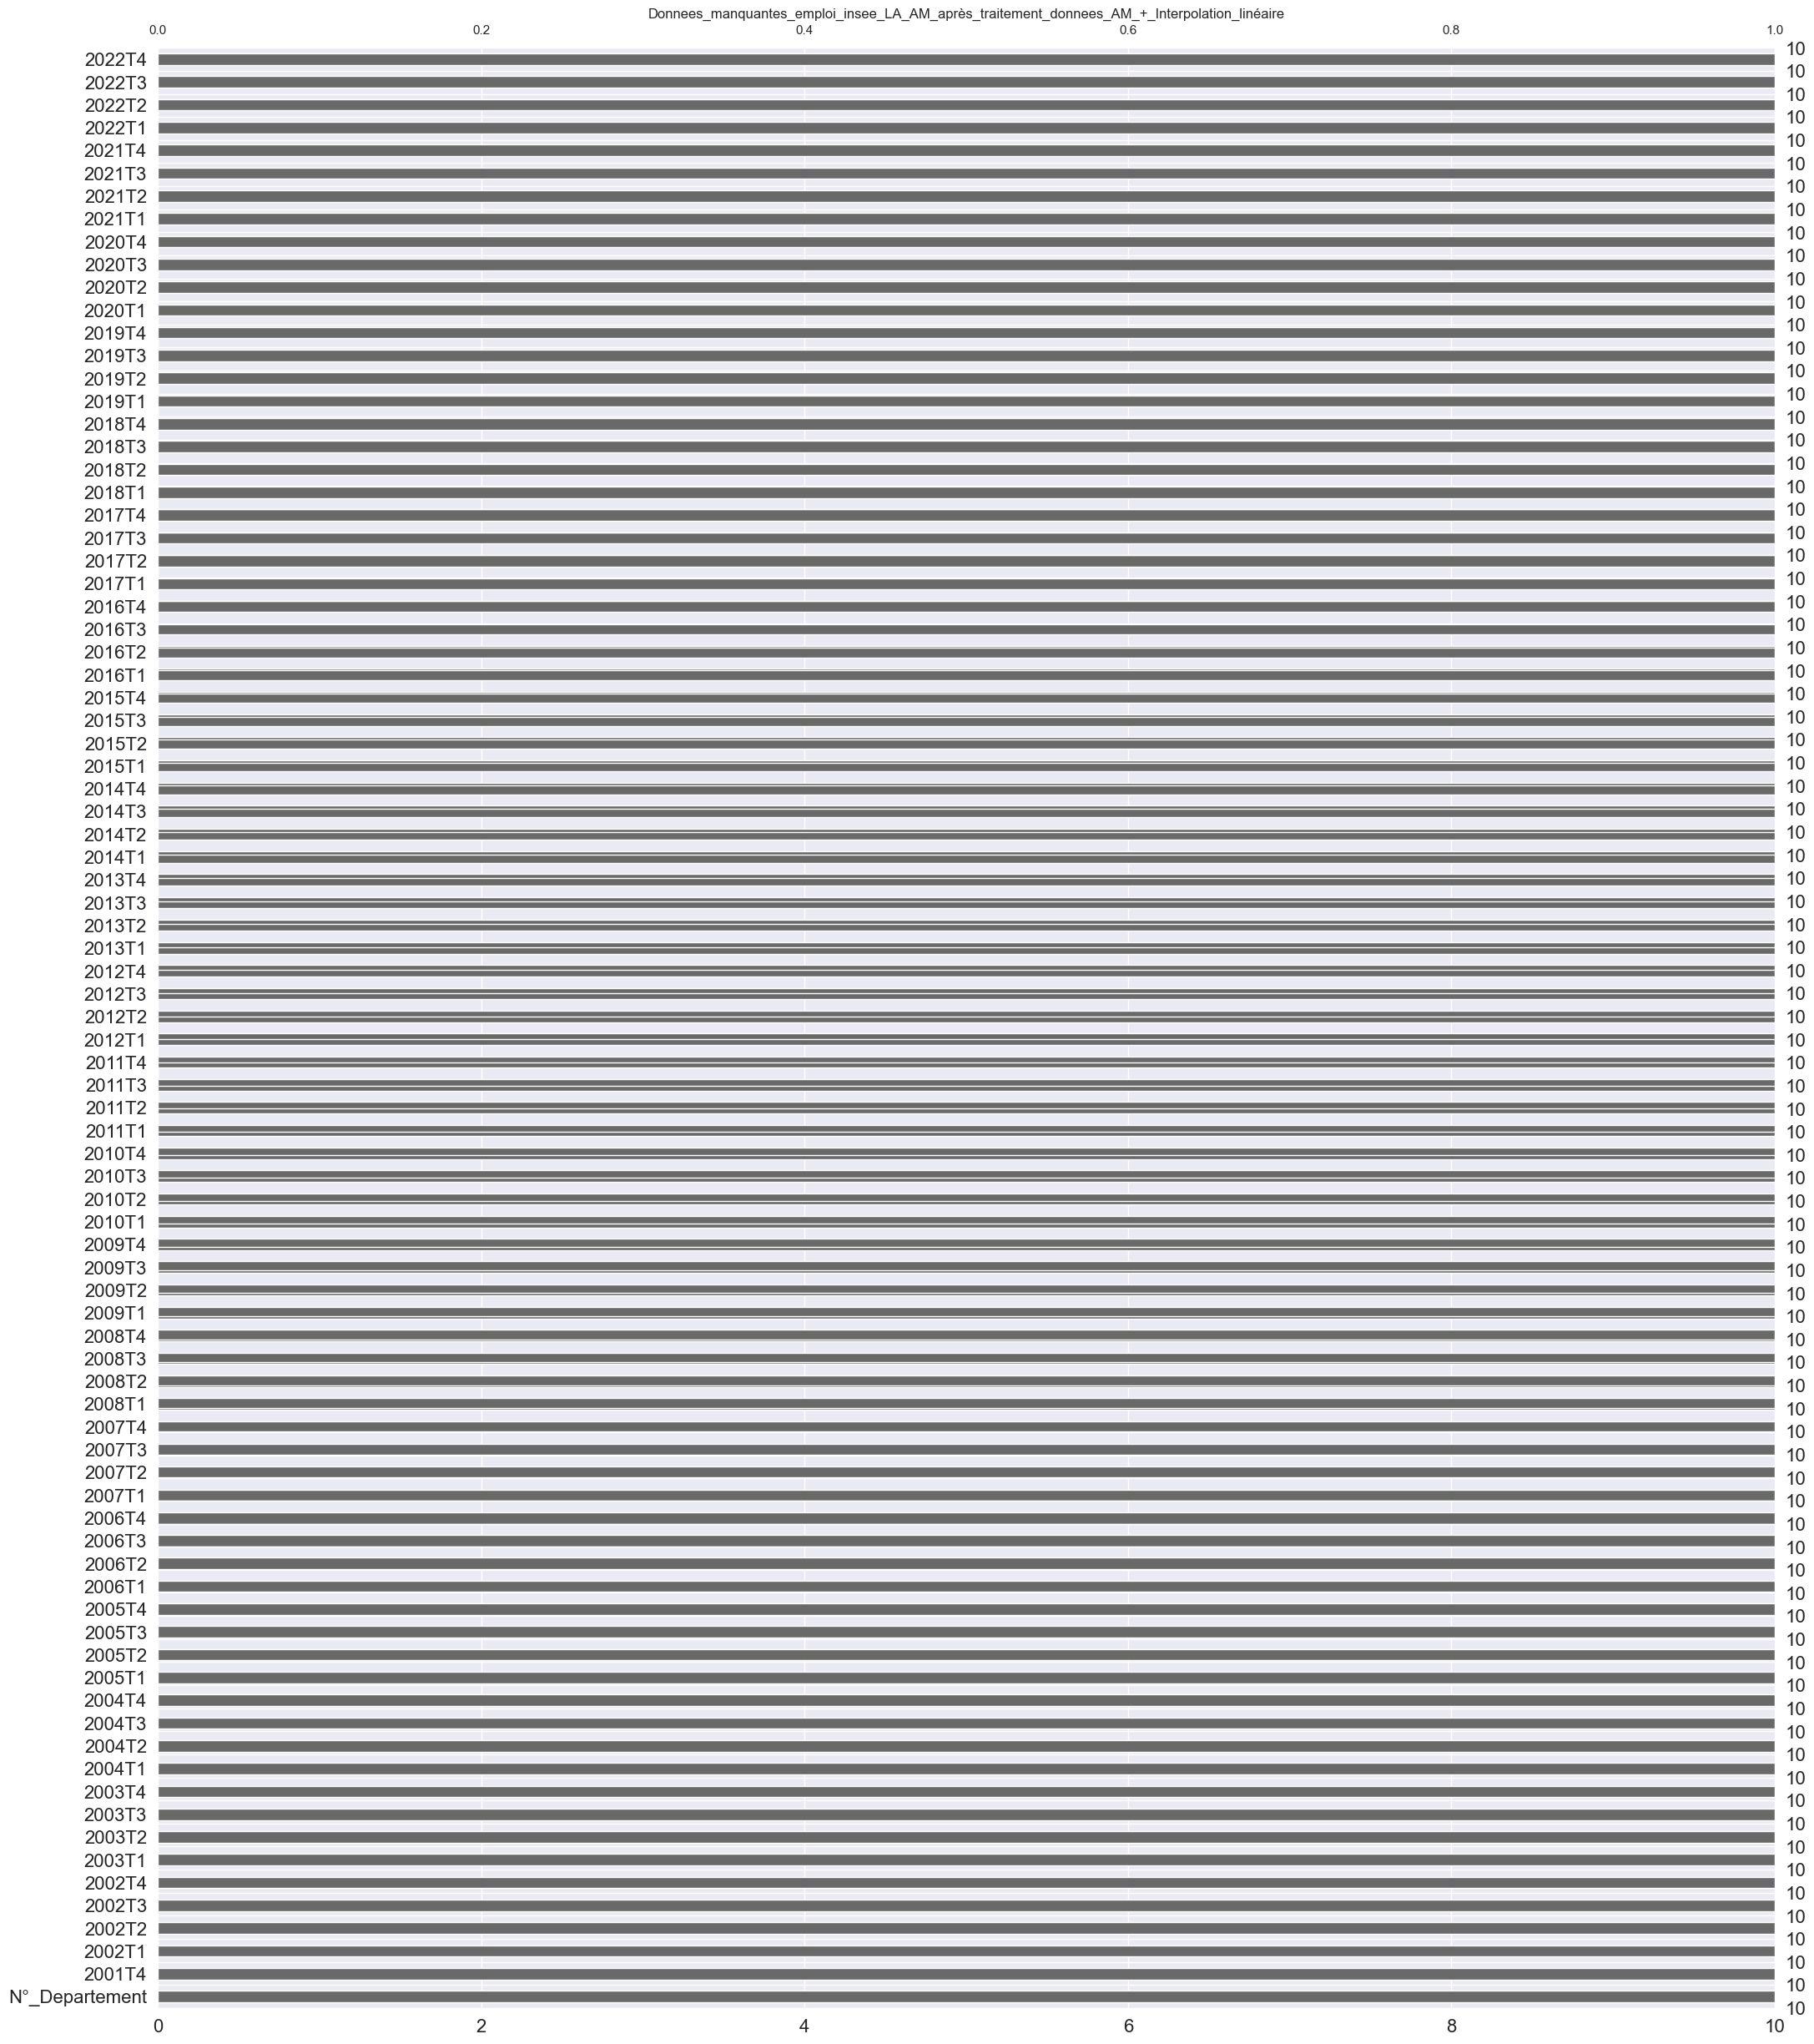

In [16]:
msno.bar(dataset_insee)
title = "Donnees_manquantes_emploi_insee_LA_AM_après_traitement_donnees_AM_+_Interpolation_linéaire"
plt.title(title)
plt.savefig(title + ".png")
plt.show()

## Affichage de graphiques décrivant les données

In [38]:
dataset_insee_44 = dataset_insee[dataset_insee["N°_Departement"] == 44]
dataset_insee_44['2022T4']

Emploi LA                 645104.0
Emploi Indus LA           455653.0
Tertiaire marchand LA     266202.0
Tertiaire non march LA    188216.0
Chom LA                        5.8
Name: 2022T4, dtype: float64

In [18]:
dataset_insee_06 = dataset_insee[dataset_insee["N°_Departement"] == 6]
dataset_insee_06

,N°_Departement,2001T4,2002T1,2002T2,2002T3,2002T4,2003T1,2003T2,2003T3,2003T4,...,2020T3,2020T4,2021T1,2021T2,2021T3,2021T4,2022T1,2022T2,2022T3,2022T4
Emploi AM,6,419917.0,421377.75,422838.5,424299.25,425760,427475.5,429191.0,430906.5,432622.0,...,407882.000000,408611.0,409196.000000,415839.000000,420726.000000,426287.0,429011.000000,433844.000000,432781.00000,434185.000000
Emploi Indus AM,6,35203.8,35217.40,35246.8,35118.80,34933,34890.2,34942.4,34732.0,34553.2,...,31817.800000,31909.4,32180.000000,32351.400000,32612.600000,32824.2,32973.200000,33107.400000,33271.20000,33505.000000
Tertiaire march AM,6,151712.4,153507.00,153934.4,154494.00,154861.4,155220.0,156114.0,156405.2,156726.6,...,179816.000000,178286.8,179505.400000,184554.600000,187511.400000,190263.2,191832.800000,193891.600000,194276.00000,194307.000000
Tertiaire non march AM OK,6,121852.0,122561.75,123271.5,123981.25,124691,125509.5,126328.0,127146.5,127965.0,...,147455.535163,148145.0,158616.043261,159007.172189,159362.130132,159910.0,153536.425405,153866.063538,154195.70167,154525.339803
Chom AM,6,10.2,10.00,9.8,9.60,9.6,9.9,10.0,9.8,10.0,...,10.100000,9.1,9.300000,9.000000,8.900000,8.4,8.300000,8.200000,8.20000,8.000000


In [19]:
chomage_LA = dataset_insee_44.loc['Chom LA'].iloc[1:]
chomage_LA

2001T4    6.5
2002T1    6.4
2002T2    6.4
2002T3    6.4
2002T4    6.5
         ... 
2021T4    6.1
2022T1    5.9
2022T2    6.0
2022T3    6.0
2022T4    5.8
Name: Chom LA, Length: 85, dtype: object

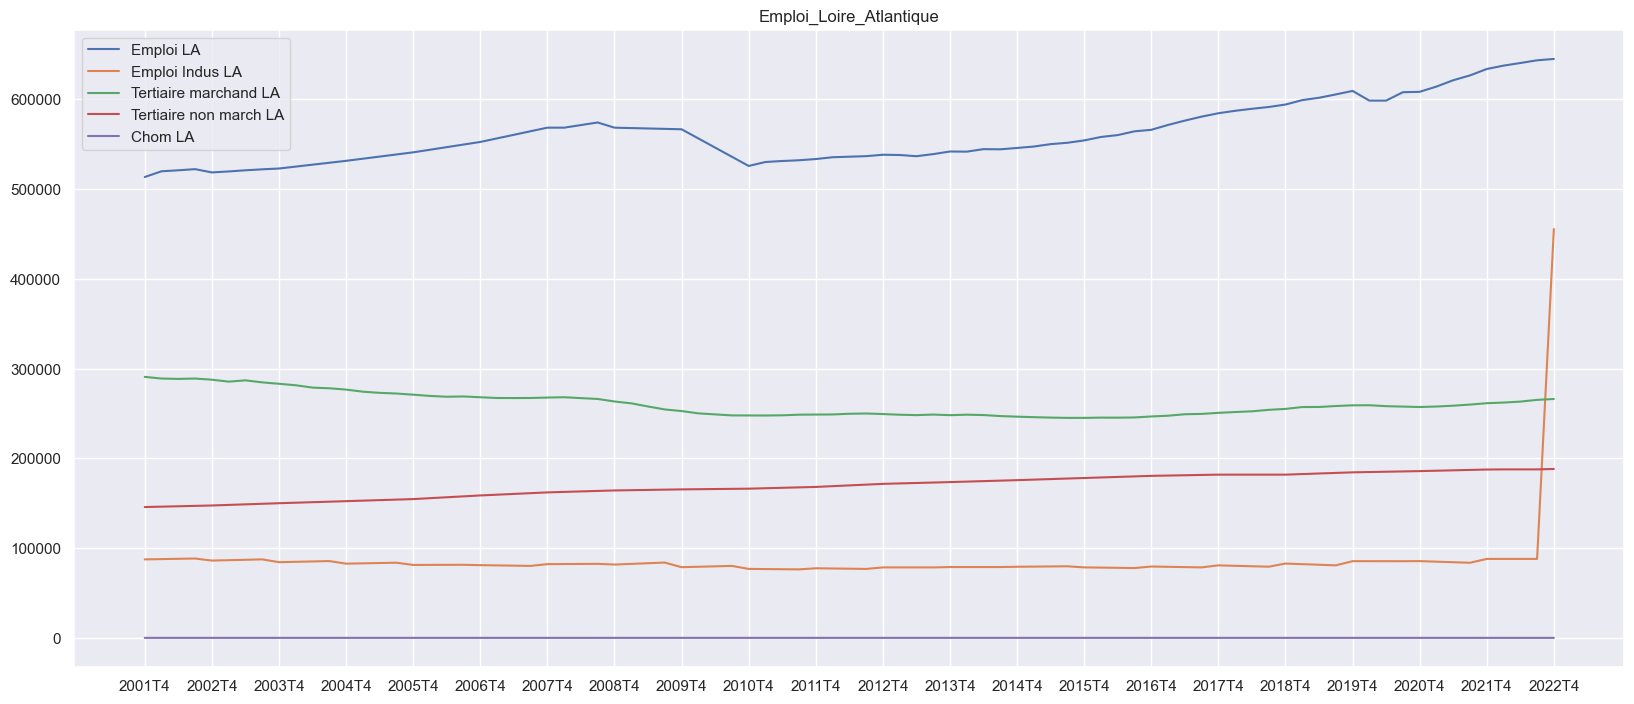

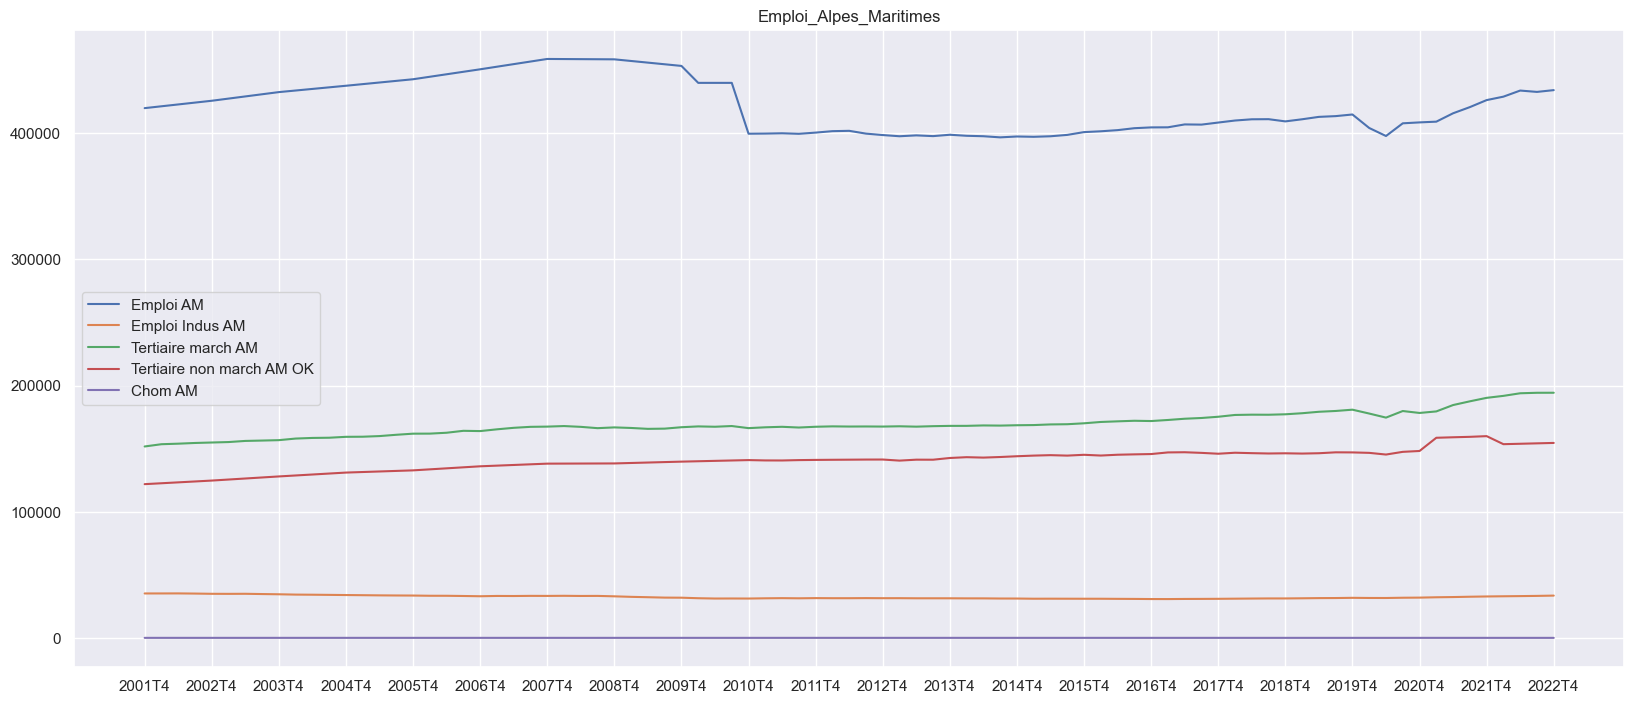

In [20]:
dataframes = [dataset_insee_44, dataset_insee_06]
x_y_axis_dataframe_slicing = slice(1,None)
ticks_labels = list(dataset_insee.filter(axis=AXE_COLONNES, regex="\d{4}T4").columns)
for i in range(len(dataframes)):
    dataframe = dataframes[i]
    departement = "Loire_Atlantique" if i == 0 else "Alpes_Maritimes"
    title = "Emploi_" + departement
    for row_label in dataframe.index:
        x = list(dataframe.columns)[x_y_axis_dataframe_slicing]
        y = dataframe.loc[row_label].iloc[x_y_axis_dataframe_slicing]
        plt.xticks(range(0,85,4),labels=ticks_labels)
        plt.plot(x,y,label=row_label)
    plt.title(title)
    plt.legend()
    plt.savefig(title + ".png")
    plt.show()

In [21]:
proportions = []
for i in range(len(dataframes)) :
    zone = "LA" if i == 0 else "AM"
    libelle_colonne_emploi = "Emploi {}".format(zone)
    libelle_colonne_num_departement = "N°_Departement"
    dataframe = dataframes[i].drop(libelle_colonne_num_departement, axis=AXE_COLONNES)
    display(afficher_noms_colonnes_avec_valeurs_manquantes(dataframe))
    libelles_lignes_emploi_et_chomage = [libelle_colonne_emploi,"Chom {}".format(zone)]
    serie_emploi_total = dataframe.loc[libelle_colonne_emploi]
    dataframe_sans_emploi_total_ni_chomage = dataframe.drop(libelles_lignes_emploi_et_chomage, axis=0)
    proportion_emploi_par_secteur = dataframe_sans_emploi_total_ni_chomage.divide(serie_emploi_total).mul(100)
    display(proportion_emploi_par_secteur)
    display(proportion_emploi_par_secteur.sum(axis=0))
    proportions.append(proportion_emploi_par_secteur)

None

,2001T4,2002T1,2002T2,2002T3,2002T4,2003T1,2003T2,2003T3,2003T4,2004T1,...,2020T3,2020T4,2021T1,2021T2,2021T3,2021T4,2022T1,2022T2,2022T3,2022T4
Emploi Indus LA,17.026613,16.880535,16.908573,16.930285,16.604295,16.655347,16.700046,16.750667,16.125036,16.137844,...,14.047269,14.055287,13.822014,13.566177,13.351825,13.878854,13.79691,13.734407,13.669918,70.632487
Tertiaire marchand LA,56.632181,55.577449,55.385392,55.324001,55.468538,54.93723,55.071785,54.530881,54.136465,53.601569,...,42.386033,42.275311,41.963902,41.636104,41.477603,41.249602,41.119435,41.10175,41.208944,41.264974
Tertiaire non march LA,28.386386,28.120874,28.145737,28.160168,28.442141,28.504103,28.555307,28.616752,28.688442,28.680402,...,30.504468,30.538524,30.320204,30.046299,29.858465,29.591396,29.441492,29.308115,29.1705,29.176071


2001T4     102.04518
2002T1    100.578858
2002T2    100.439702
2002T3    100.414454
2002T4    100.514974
             ...    
2021T4     84.719852
2022T1     84.357837
2022T2     84.144271
2022T3     84.049362
2022T4    141.073532
Length: 85, dtype: object

None

,2001T4,2002T1,2002T2,2002T3,2002T4,2003T1,2003T2,2003T3,2003T4,2004T1,...,2020T3,2020T4,2021T1,2021T2,2021T3,2021T4,2022T1,2022T2,2022T3,2022T4
Emploi Indus AM,8.383514,8.357679,8.335759,8.276894,8.204857,8.161918,8.141457,8.060217,7.986926,7.904812,...,7.800736,7.809237,7.864202,7.77979,7.751506,7.700024,7.685864,7.631176,7.687768,7.716757
Tertiaire march AM,36.12914,36.429783,36.40501,36.411566,36.372933,36.310853,36.374015,36.296784,36.227145,36.413064,...,44.085299,43.632403,43.867829,44.381263,44.568532,44.632654,44.715124,44.691548,44.890141,44.752122
Tertiaire non march AM OK,29.018115,29.085957,29.153329,29.220238,29.286687,29.36063,29.433982,29.506749,29.57894,29.669609,...,36.151518,36.255754,38.762853,38.237677,37.87789,37.512286,35.788459,35.465758,35.629037,35.589746


2001T4    73.530769
2002T1    73.873419
2002T2    73.894099
2002T3    73.908698
2002T4    73.864478
            ...    
2021T4    89.844964
2022T1    88.189446
2022T2    87.788482
2022T3    88.206946
2022T4    88.058625
Length: 85, dtype: object

In [22]:
trimestres_interessants = ["2007T2","2012T2","2017T2","2022T2"]
dataset_insee_proportions_emploi_LA = proportions[0]
dataset_insee_proportions_emploi_AM = proportions[1]
proportions_donnees_elections_LA = dataset_insee_proportions_emploi_LA[trimestres_interessants]
proportions_donnees_elections_AM = dataset_insee_proportions_emploi_AM[trimestres_interessants]
display(proportions_donnees_elections_LA)
proportions_elections = [proportions_donnees_elections_LA,proportions_donnees_elections_AM]
display(proportions_elections)

,2007T2,2012T2,2017T2,2022T2
Emploi Indus LA,14.355183,14.373275,13.682119,13.734407
Tertiaire marchand LA,47.671926,46.575532,43.234193,41.10175
Tertiaire non march LA,28.614216,31.686498,31.438121,29.308115


[                           2007T2     2012T2     2017T2     2022T2
 Emploi Indus LA         14.355183  14.373275  13.682119  13.734407
 Tertiaire marchand LA   47.671926  46.575532  43.234193   41.10175
 Tertiaire non march LA  28.614216  31.686498  31.438121  29.308115,
                               2007T2     2012T2     2017T2     2022T2
 Emploi Indus AM             7.294463   7.822623    7.58022   7.631176
 Tertiaire march AM           36.6104  41.678327  42.678106  44.691548
 Tertiaire non march AM OK  30.134873   35.14279  36.153002  35.465758]

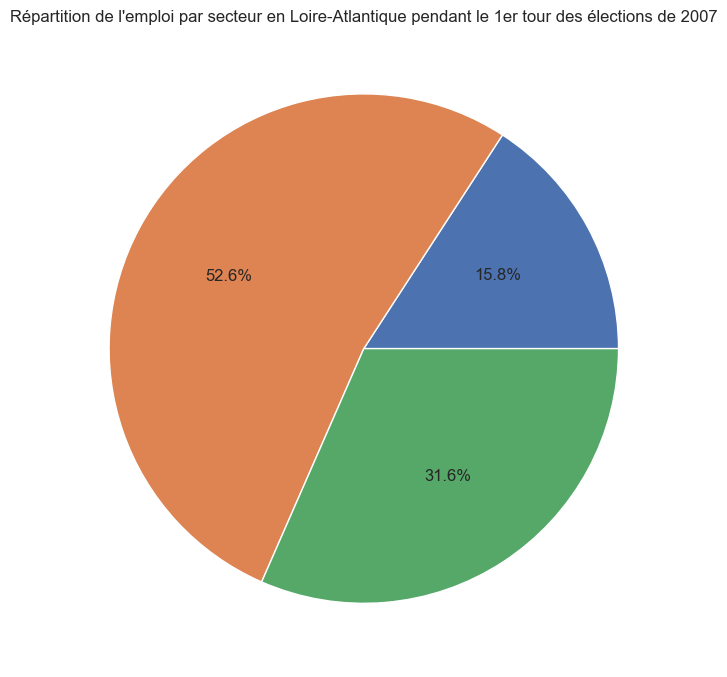

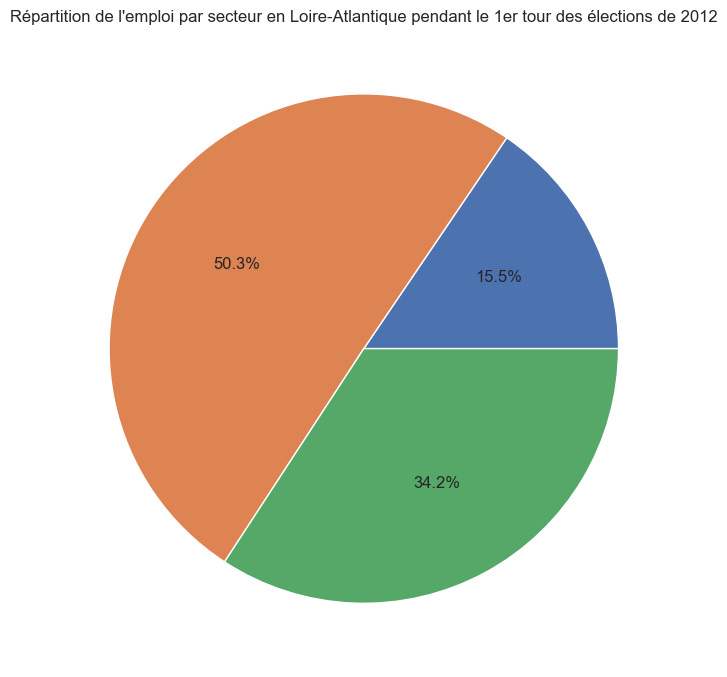

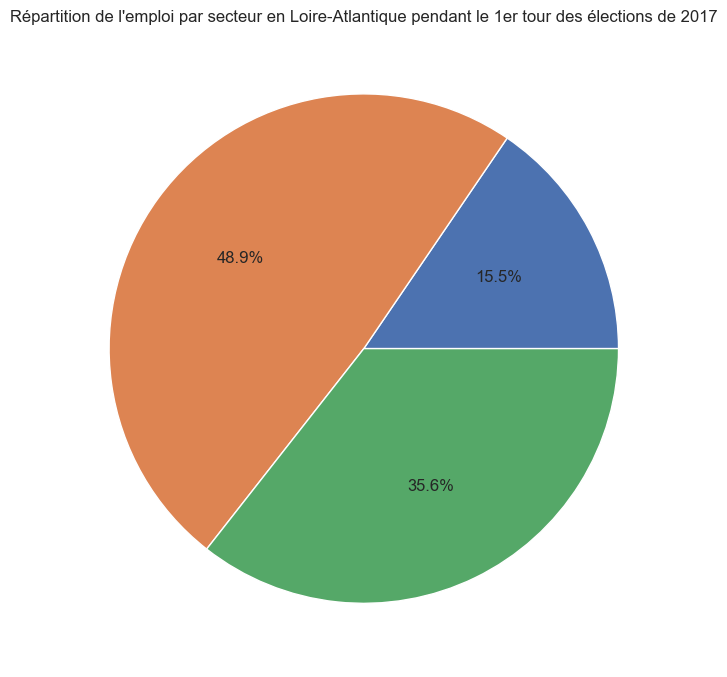

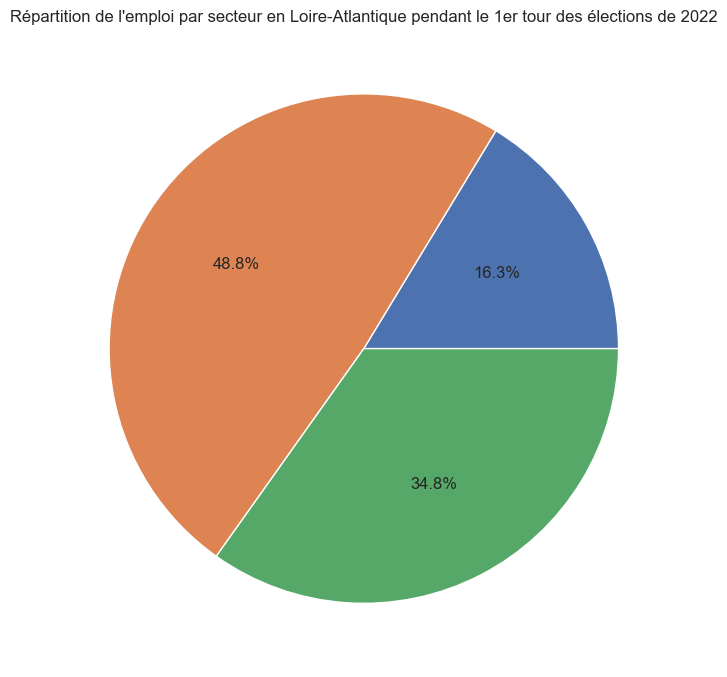

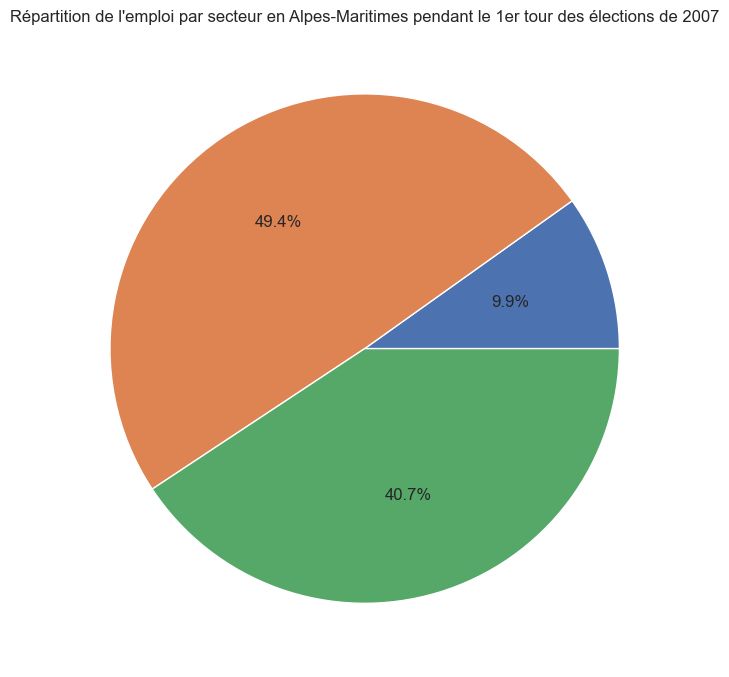

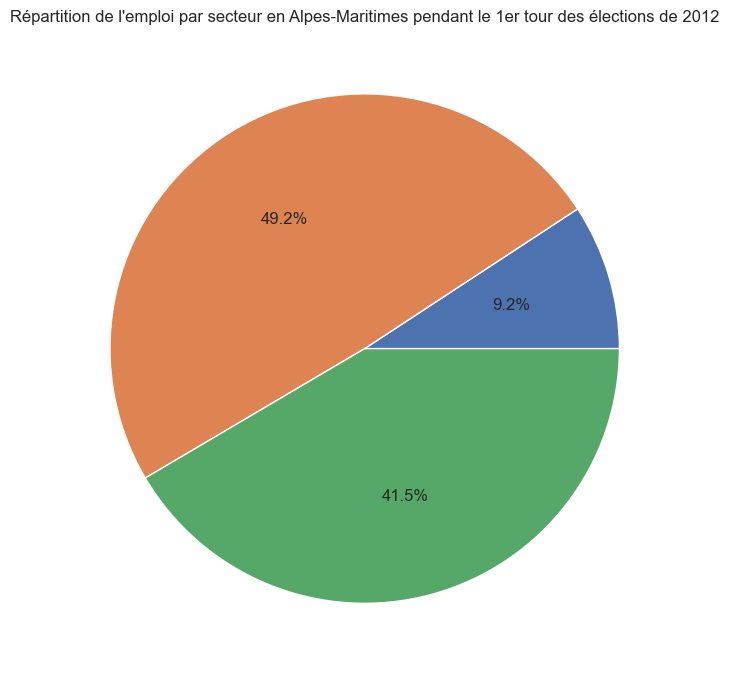

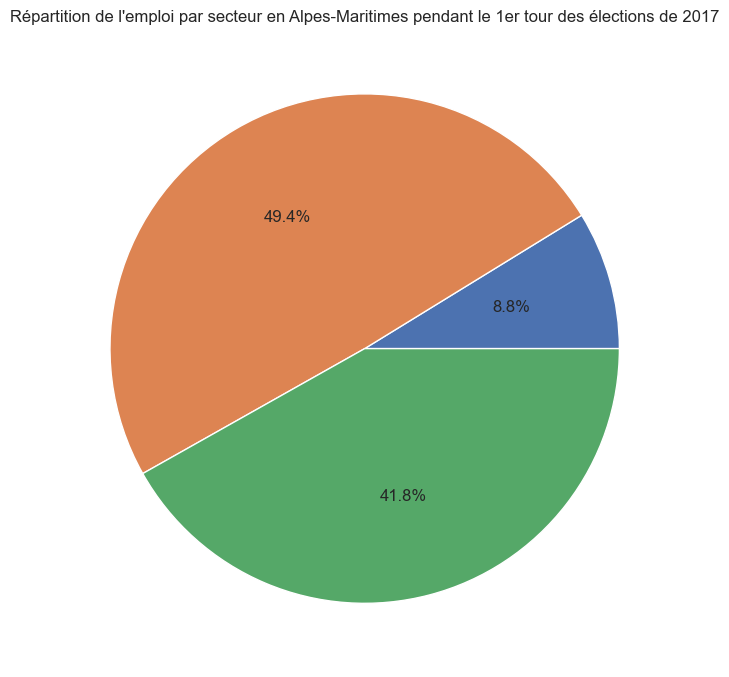

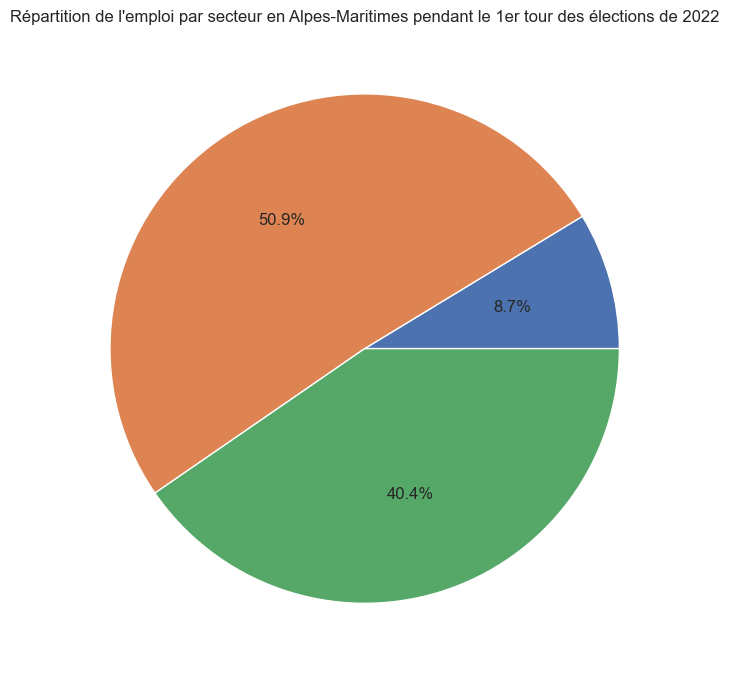

In [23]:
for i in range(len(proportions_elections)) :
    proportion = proportions_elections[i]
    zone = "Loire-Atlantique" if i == 0 else "Alpes-Maritimes"
    for column in proportion.columns:
        title = 'Répartition de l\'emploi par secteur en {} pendant le 1er tour des élections de {}'.format(zone, column[0:4])
        fig, ax = plt.subplots()
        plt.title(title)
        ax.pie(proportion[column], autopct='%1.1f%%')
        plt.savefig(title + ".png")

## Traitement des données des élections
### Obtention d'un jeu de données par candidats

In [24]:
donnees_1er_tour_2007 = pd.read_excel("./data/Presidentielle_2007_Tour_1.xls", sheet_name="Départements T1")
donnees_1er_tour_2012 = pd.read_excel("./data/Presidentielle_2012_Tour_1.xls", sheet_name="Départements T1")
donnees_1er_tour_2017 = pd.read_excel("./data/Presidentielle_2017_Resultats_Tour_1_c.xls", sheet_name="Départements Tour 1")
donnees_1er_tour_2022 = pd.read_excel("./data/resultats-par-niveau-dpt-t1-france-entiere.xlsx")
global_columns = ['Code du département', 'Libellé du département', 'Inscrits',
       'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs et nuls',
       '% Blancs/Ins', '% Blancs/Vot', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés',
       '% Exp/Ins', '% Exp/Vot']
donnees_1er_tour_2022 = donnees_1er_tour_2022.drop("Etat saisie", axis=AXE_COLONNES)
donnees_1er_tour_2022.insert(7,"Blancs et nuls",donnees_1er_tour_2022["Blancs"] + donnees_1er_tour_2022["Nuls"])

dataframes_2017_2022 = [donnees_1er_tour_2017, donnees_1er_tour_2022]
for i in range(len(dataframes_2017_2022)):
    dataframe = dataframes_2017_2022[i]
    display(dataframe.columns)
    percentage_of_null_votes_and_blank_ballots_among_registered_people_column_name = "% BlNuls/Ins"
    dataframe.insert(8,percentage_of_null_votes_and_blank_ballots_among_registered_people_column_name,(dataframe["Blancs et nuls"] / dataframe["Inscrits"]) * 100)    
    percentage_of_null_votes_and_blank_ballots_among_voters_column_name = "% BlNuls/Vot"
    dataframe.insert(9,percentage_of_null_votes_and_blank_ballots_among_voters_column_name,(dataframe["Blancs et nuls"] / dataframe["Votants"]) * 100)
    if i == 0 :
        global_columns.append(percentage_of_null_votes_and_blank_ballots_among_registered_people_column_name)
        global_columns.append(percentage_of_null_votes_and_blank_ballots_among_voters_column_name)
global_columns

Index(['Code du département', 'Libellé du département', 'Inscrits',
       'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs et nuls',
       '% Blancs/Ins', '% Blancs/Vot', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés',
       '% Exp/Ins', '% Exp/Vot', 'Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins',
       '% Voix/Exp', 'Sexe.1', 'Nom.1', 'Prénom.1', 'Voix.1', '% Voix/Ins.1',
       '% Voix/Exp.1', 'Sexe.2', 'Nom.2', 'Prénom.2', 'Voix.2', '% Voix/Ins.2',
       '% Voix/Exp.2', 'Sexe.3', 'Nom.3', 'Prénom.3', 'Voix.3', '% Voix/Ins.3',
       '% Voix/Exp.3', 'Sexe.4', 'Nom.4', 'Prénom.4', 'Voix.4', '% Voix/Ins.4',
       '% Voix/Exp.4', 'Sexe.5', 'Nom.5', 'Prénom.5', 'Voix.5', '% Voix/Ins.5',
       '% Voix/Exp.5', 'Sexe.6', 'Nom.6', 'Prénom.6', 'Voix.6', '% Voix/Ins.6',
       '% Voix/Exp.6', 'Sexe.7', 'Nom.7', 'Prénom.7', 'Voix.7', '% Voix/Ins.7',
       '% Voix/Exp.7', 'Sexe.8', 'Nom.8', 'Prénom.8', 'Voix.8', '% Voix/Ins.8',
       '% Voix/Exp.8', 'Sexe.9', 'Nom.9', 'Prénom.9', 'Voi

Index(['Code du département', 'Libellé du département', 'Inscrits',
       'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs et nuls',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'Sexe', 'Nom',
       'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp', 'Sexe.1', 'Nom.1',
       'Prénom.1', 'Voix.1', '% Voix/Ins.1', '% Voix/Exp.1', 'Sexe.2', 'Nom.2',
       'Prénom.2', 'Voix.2', '% Voix/Ins.2', '% Voix/Exp.2', 'Sexe.3', 'Nom.3',
       'Prénom.3', 'Voix.3', '% Voix/Ins.3', '% Voix/Exp.3', 'Sexe.4', 'Nom.4',
       'Prénom.4', 'Voix.4', '% Voix/Ins.4', '% Voix/Exp.4', 'Sexe.5', 'Nom.5',
       'Prénom.5', 'Voix.5', '% Voix/Ins.5', '% Voix/Exp.5', 'Sexe.6', 'Nom.6',
       'Prénom.6', 'Voix.6', '% Voix/Ins.6', '% Voix/Exp.6', 'Sexe.7', 'Nom.7',
       'Prénom.7', 'Voix.7', '% Voix/Ins.7', '% Voix/Exp.7', 'Sexe.8', 'Nom.8',
       'Prénom.8', 'Voix.8', '% Voix/Ins.8', '% Voix/Exp.8', 'Sexe.9', 'Nom.9'

['Code du département',
 'Libellé du département',
 'Inscrits',
 'Abstentions',
 '% Abs/Ins',
 'Votants',
 '% Vot/Ins',
 'Blancs et nuls',
 '% Blancs/Ins',
 '% Blancs/Vot',
 '% Nuls/Ins',
 '% Nuls/Vot',
 'Exprimés',
 '% Exp/Ins',
 '% Exp/Vot',
 '% BlNuls/Ins',
 '% BlNuls/Vot']

In [26]:
#display(columns_only_present_in_2017_2022)
#dataframes_elections = [donnees_1er_tour_2007,donnees_1er_tour_2012,donnees_1er_tour_2017,donnees_1er_tour_2022]
#Suppression des colonnes seulement présentes en 2017 et 2022 et impossibles à recalculer avec les données de 2007 et 2012
#donnees_1er_tour_2017[columns_only_present_in_2017_2022]
#donnees_1er_tour_2022.drop(columns_only_present_in_2017_2022, axis=1, inplace=True)
#for column_name in columns_only_present_in_2017_2022 :
   #global_columns.remove(column_name)

In [33]:

donnees_1er_tour_2017["Code du département"] = donnees_1er_tour_2017["Code du département"].astype(str)
donnees_1er_tour_2017["Code du département"].unique()
donnees_1er_tour_2017_44_06 = donnees_1er_tour_2017[(donnees_1er_tour_2017["Code du département"] == '44') | (donnees_1er_tour_2017["Code du département"] == '06')]
#Isolement des candidats
candidates_df = []
columns = ['Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp']
for i in range(11):
    regex = '(Sexe|Nom|Prénom|Voix|% Voix/Ins|% Voix/Exp)'
    if i > 0 :
        regex = regex + '\.' + str(i)
    regex = regex + '$'
    candidates = donnees_1er_tour_2017_44_06.filter(regex=regex)
    candidates.columns = columns
    candidates_df.append(candidates)
total_candidates = pd.concat(candidates_df, axis=0)
display(total_candidates)

,Sexe,Nom,Prénom,Voix,% Voix/Ins,% Voix/Exp
5,F,LE PEN,Marine,163141,21.42,27.75
44,M,MACRON,Emmanuel,232602,23.41,28.66
5,M,FILLON,François,161036,21.14,27.39
44,M,MÉLENCHON,Jean-Luc,178357,17.95,21.98
5,M,MACRON,Emmanuel,111953,14.70,19.04
44,M,FILLON,François,159703,16.07,19.68
5,M,MÉLENCHON,Jean-Luc,87941,11.54,14.96
44,F,LE PEN,Marine,111194,11.19,13.70
5,M,DUPONT-AIGNAN,Nicolas,25175,3.30,4.28
44,M,HAMON,Benoît,65140,6.56,8.03


## Catégrorisation des candidats par bord politique

In [37]:
# Détermination des noms unique des candidats
da

Nom            Prénom  
ARTHAUD        Nathalie    2
ASSELINEAU     François    2
CHEMINADE      Jacques     2
DUPONT-AIGNAN  Nicolas     2
FILLON         François    2
HAMON          Benoît      2
LASSALLE       Jean        2
LE PEN         Marine      2
MACRON         Emmanuel    2
MÉLENCHON      Jean-Luc    2
POUTOU         Philippe    2
dtype: int64

In [28]:
donnes_securite_dept = pd.read_csv("./data/donnee-securité.csv",
                                   sep=';')
# Filtrer les données de sécurité sur lles départements 44 et 06
donnees_securite_44_06 = donnes_securite_dept[
 (donnes_securite_dept['Code.département'] == '6') | (donnes_securite_dept['Code.département'] == '06') | (
                donnes_securite_dept['Code.département'] == '44')]

display(donnees_securite_44_06)
display(donnees_securite_44_06)

,classe,annee,Code.département,Code.région,unité.de.compte,millPOP,millLOG,faits,POP,LOG,tauxpourmille
5,Coups et blessures volontaires,16,6,93,victime,16,16,4804,1083704,"761857,023282979","4,43294478935207"
44,Coups et blessures volontaires,16,44,52,victime,16,16,3924,1380852,"729713,912222526","2,84172380530281"
106,Coups et blessures volontaires,17,6,93,victime,17,17,4573,1083310,"766747,524813269","4,22132169000563"
145,Coups et blessures volontaires,17,44,52,victime,17,17,4249,1394909,"740924,187780818","3,04607684085485"
207,Coups et blessures volontaires,18,6,93,victime,18,18,4992,1086219,"772316,51330812","4,59575831393117"
...,...,...,...,...,...,...,...,...,...,...,...
8225,Destructions et dégradations volontaires,20,44,52,infraction,20,19,11099,1445171,"764010,312166239","7,68006000673969"
8287,Destructions et dégradations volontaires,21,6,93,infraction,20,19,10736,1097410,"778290,897542165","9,78303459964826"
8326,Destructions et dégradations volontaires,21,44,52,infraction,20,19,11463,1445171,"764010,312166239","7,9319333144659"
8388,Destructions et dégradations volontaires,22,6,93,infraction,20,19,10514,1097410,"778290,897542165","9,58074010625017"


,classe,annee,Code.département,Code.région,unité.de.compte,millPOP,millLOG,faits,POP,LOG,tauxpourmille
5,Coups et blessures volontaires,16,6,93,victime,16,16,4804,1083704,"761857,023282979","4,43294478935207"
44,Coups et blessures volontaires,16,44,52,victime,16,16,3924,1380852,"729713,912222526","2,84172380530281"
106,Coups et blessures volontaires,17,6,93,victime,17,17,4573,1083310,"766747,524813269","4,22132169000563"
145,Coups et blessures volontaires,17,44,52,victime,17,17,4249,1394909,"740924,187780818","3,04607684085485"
207,Coups et blessures volontaires,18,6,93,victime,18,18,4992,1086219,"772316,51330812","4,59575831393117"
...,...,...,...,...,...,...,...,...,...,...,...
8225,Destructions et dégradations volontaires,20,44,52,infraction,20,19,11099,1445171,"764010,312166239","7,68006000673969"
8287,Destructions et dégradations volontaires,21,6,93,infraction,20,19,10736,1097410,"778290,897542165","9,78303459964826"
8326,Destructions et dégradations volontaires,21,44,52,infraction,20,19,11463,1445171,"764010,312166239","7,9319333144659"
8388,Destructions et dégradations volontaires,22,6,93,infraction,20,19,10514,1097410,"778290,897542165","9,58074010625017"


## Aggrégation des résultats

In [ ]:
global_results = donnees_1er_tour_2017_44_06[global_columns]
display(global_results)

election_results_2017 = global_results.join(total_candidates, how='inner')
election_results_2017